## Meta data

In [11]:
import netCDF4 as nc4
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import cm
from tqdm import tqdm
import scipy.ndimage as nd
import scipy.interpolate as interp
from matplotlib.gridspec import GridSpec
import matplotlib.colors as col #ListedColormap
import matplotlib.path as mpp
import h5py  # For NEW Matlab files (AMEDA)
import scipy.io as sio # For OLD Matlab files
from matplotlib import rcParams
rcParams['pcolor.shading']='auto'

expname='qwa116'  #      <============ Change run name here !

pathdir='/home6/datawork/abarboni/CROCO/TEMP_1km/SAVE_HIS-AVG/'
path_ameda='/home6/datawork/abarboni/CROCO/RESULT/'+expname.upper()+'/'

filename=pathdir+expname+'_his.nc'
avg_name=pathdir+expname+'_avg.nc'
gridname=pathdir+'grd_lat385_1km.nc' #1km_x100.nc'

timestep=2 ## time in day between time step of netcdf _avg file
rg=1 # side padding to reduce data size 
depth_m=300  # index of deepest level extracted
depth_surf=15  ## depth of near surface value chosen, in meters
Xmax=100 # (half) window size in km
f_coriolis=1e-4
mldthres=0.1

Navg=2   ### padding between _his and _avg files : timestep(avg) = Navg*timestep(his)
Nt=1 # timestep selection (keep it to 1)

str_title='Run '+expname.upper()+' - AE 1km ERA5 1-hour '
str_title

'Run QWA116 - AE 1km ERA5 1-hour '

## Loading data

In [3]:
### Grid   ### MAKE SURE IT IS THE GOOD ONE !
f=nc4.Dataset(gridname)   
x_rho=f['x_rho'][rg:-rg,rg:-rg]/1000 ; y_rho=f['y_rho'][rg:-rg,rg:-rg]/1000
xi_rho=x_rho[0,:]
xmid=int(f.dimensions['xi_rho'].size/2)
f.close()
x_psi=(x_rho[1:,1:]+x_rho[1:,:-1]+x_rho[:-1,1:]+x_rho[:-1,:-1])/4
y_psi=(y_rho[1:,1:]+y_rho[1:,:-1]+y_rho[:-1,1:]+y_rho[:-1,:-1])/4
dx=np.diff(x_rho, axis=1)[0,0]*1000 ; dy=np.diff(y_rho, axis=0)[0,0]*1000 # in meters
x_div=x_rho[1:-1,1:-1] ; y_div=y_rho[1:-1,1:-1]
xi_psi=x_psi[0]

In [4]:
### AVG Data
f=nc4.Dataset(avg_name) #filename)
srho=f['s_rho'][:]
H0=f['h'][0,0] ; hc=f['hc'][:]
### Streching coeff
Csr=f['Cs_r'][:] ; sw=f['s_w'][:] ; Csw=f['Cs_w'][:] 
#######z0=hc*srho+(H0-hc)*Csr ## OLD S COORD
z0=H0*(hc*srho+H0*Csr)/(hc+H0) ## NEW S COORD
z_w= H0*(hc*sw+H0*Csw)/(hc+H0) 

time=f['time'][::Nt]/24/3600 #time in days

qtot=f['shflux'][:,rg:-rg,rg:-rg]       ### FLUXES 
ustr=f['sustr'][:,rg:-rg,rg:-rg] ; vstr=f['svstr'][:,rg:-rg,rg:-rg] # in N/m^2
f.close()

In [52]:
ids=np.argmin(np.abs(z0+depth_surf))
idmax=np.argmin(np.abs(z0+depth_m)) 
zvert=z0[idmax:] ; z_dzt=z_w[idmax:]
Nvert=len(z0[:]) ; Nx=len(xi_rho) ; Ny=len(xi_rho) ; Ns=len(time) #numb timesteps

In [7]:
### HIS file  = BIG DATA
f=nc4.Dataset(filename) 
U=f['u'][int(Navg/2)::Navg,ids,rg:-rg,rg:-rg]   
V=f['v'][int(Navg/2)::Navg,ids,rg:-rg,rg:-rg]

SST=f['temp'][int(Navg/2)::Navg,-1,rg:-rg,rg:-rg] 
time_h=f['time'][int(Navg/2)::Navg]/24/3600#time in days
temp_h=f['temp'][int(Navg/2)::Navg,idmax:,rg:-rg,rg:-rg]
AKv=f['AKt'][int(Navg/2)::Navg,idmax:,rg:-rg,rg:-rg]
Eps=f['gls'][int(Navg/2)::Navg,idmax:,rg:-rg,rg:-rg]  ### Warning : dissipation rate epsilon is under 'gls' variable depending on GLS_MIXING choices
f.close()
Nh=len(time_h)

### Checking vertical resolution

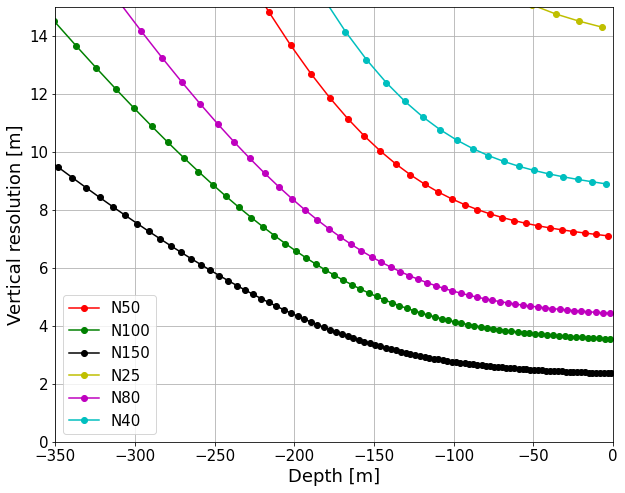

In [8]:
def zlevs(N,hc,H0,theta_s):
    srho=np.linspace(-1+1/2/N,0-1/2/N,N)
    csf=(1-np.cosh(theta_s*srho))/(np.cosh(theta_s)-1)
    Csr=csf ### because theta_b = 0
    z0=H0*(hc*srho+H0*Csr)/(hc+H0)
    return z0

plt.figure(0, figsize=(10,8))
z1=zlevs(50,400,3000,8)
z2=zlevs(100,400,3000,8)
z3=zlevs(150,400,3000,8)
z4=zlevs(25,400,3000,8)
z5=zlevs(80,400,3000,8)
z6=zlevs(40,400,3000,8)
#plt.plot(z0[1:],np.diff(z0),'-ob',label=expname.upper())# : N100, theta=8, hc=400')
plt.plot(z1[1:],np.diff(z1),'-or', label='N50')
plt.plot(z2[1:],np.diff(z2),'-og', label='N100')
plt.plot(z3[1:],np.diff(z3),'-ok', label='N150')
plt.plot(z4[1:],np.diff(z4),'-oy', label='N25')
plt.plot(z5[1:],np.diff(z5),'-om', label='N80')
plt.plot(z6[1:],np.diff(z6),'-oc', label='N40')
plt.ylim([0,15]); plt.xlim([-350,0])
plt.ylabel('Vertical resolution [m]',size=18)
plt.xlabel('Depth [m]',size=18)
plt.legend(fontsize=15) ; plt.grid() ; plt.tick_params(labelsize=15)

### Checking Heat fluxes

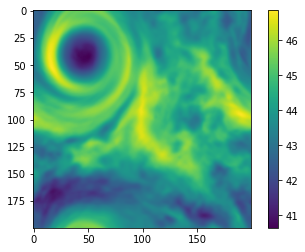

In [9]:
plt.imshow(qtot[-10]) ; plt.colorbar()
Qmean=np.mean(qtot, axis=(1,2))
Umean=np.mean(ustr,axis=(1,2)) ; Vmean=np.mean(vstr,axis=(1,2)) ; Wmean=np.sqrt(Umean**2+Vmean**2)
Wspeed=np.sqrt(Wmean/0.0016/1.2)

In [ ]:
### Vorticity
Vort=(np.diff(V,axis=2)/dx-np.diff(U,axis=1)/dy)/f_coriolis


## Computing MLD

In [12]:
MLDind_h=np.zeros((Nh, Nx,Nx))   #### HIS version
for t in tqdm(range(Nh)):
    DT=(np.abs(temp_h[t,:]-temp_h[t,-1])<mldthres)
    MLDind_h[t]=np.argmin(~DT,axis=0)

100%|██████████| 389/389 [00:07<00:00, 50.13it/s]


<ipython-input-40-25248a680751>:12: UserWarning: FixedFormatter should only be used together with FixedLocator
  CB.ax.set_yticklabels(labels)


[Text(1, 30.0, '-108'),
 Text(1, 35.0, '-87'),
 Text(1, 40.0, '-68'),
 Text(1, 45.0, '-49'),
 Text(1, 50.0, '-30'),
 Text(1, 55.0, '-12')]

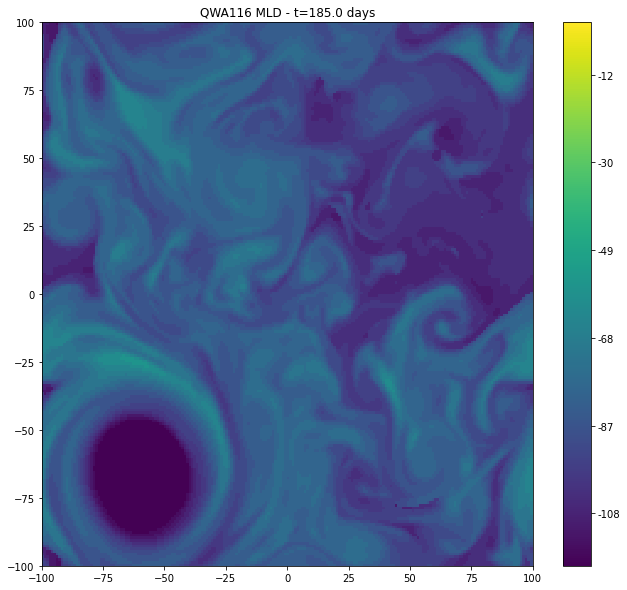

In [40]:
t=92 ### Check MLD
MLDmax=120
plt.figure(0,figsize=(11,10))
plt.pcolor(xi_rho, xi_rho,MLDind_h[t], vmin=np.argmin(np.abs(zvert+MLDmax)) , vmax=len(zvert)-1)
#ticks = [ x for x,i in enumerate(zvert.astype(int))] ; labels=[str(x) for x in zvert.astype(int)]
CB=plt.colorbar() #; CB.ax.set_yticks(ticks) ; 
#CB.ax.set_yticklabels(labels[::7])
plt.title(str_title[4:10]+ ' MLD - t='+'%3.1f'%time_h[t]+' days')
ticks=CB.get_ticks()
fmld = interp.interp1d(np.arange(len(zvert)), zvert)
labels=['%3.0f'%(fmld(x)) for x in ticks]
CB.ax.set_yticklabels(labels)

## Loading AMEDA result (with HDF5 refs)

In [33]:
## Param_eddy_tracking
params_dict = sio.loadmat(path_ameda+'param_eddy_tracking.mat')
deg=int(params_dict['deg']) ; resol=int(params_dict['resol'])

## Grid
grid_dict = sio.loadmat(path_ameda+'gridvel_deg'+str(deg)+'_resol'+str(resol)+'.mat')
x_am=grid_dict['x'] ; y_am=grid_dict['y']
## Tracks
D = h5py.File(path_ameda+'eddy_tracks.mat','r')  ## Or tracks2.mat ??
tracks=D['tracks']
Ned=tracks['step'].shape[0]
## Syntax : 
#D[D[tracks['shapes1'][Eddy_nb,0]][0][Timestep]][Streamline, X/Y]

print('Number of timesteps :'+str(int(params_dict['stepF'])) ) ## Checking time and shape
print('Number of eddies :'+str(Ned))

Number of timesteps :388
Number of eddies :229


In [34]:
StepEddy=np.zeros((Ned, len(time)))  ## Presence matrix
#StepEddy=np.zeros((Ned, len(time_h)+1))  ## Presence matrix
Polarity=np.zeros(Ned)
for i in range(Ned):
    StepEddy[i,D[tracks['step'][i,0]][0].astype(int)-1]=1  
    ### "-1" is important because steps are counted in Matlab, in Python first index starts at 0
    Polarity[i]=np.mean(D[tracks['type'][i,0]][0].astype(int))
Color=np.zeros(Ned).astype(str)
Color[Polarity==-1]='b' ; Color[Polarity==1]='r'

Text(0.5, 1.0, 'Eddy occurence matrix')

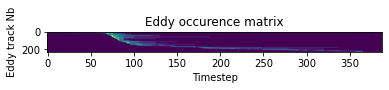

In [35]:
plt.imshow(StepEddy, aspect=1/10) ; plt.xlabel('Timestep') ; plt.ylabel('Eddy track Nb')
plt.title('Eddy occurence matrix')
## np.where(StepEddy[0,:]) #: to have index of first appearance

## Selecting anticyclone main track (touchy)

This step is touchy as the main anticyclone tracked can be considered simply as the one having the longest lifetime.
However AMEDA does not understand periodic borders (in the considered version). Then if the anticyclone crosses the domain borders, you have to manually change track by indicating with the variable `DayEddy` the timestep range for each partial track.

Check later with SST plots that the considered main track is always in the domain (by showing also track numbers)

### Automatic version (in case no border crossing)

In [36]:
MainEddy=np.where((np.sum(StepEddy, axis=1)>200) & (Polarity==-1))[0]
print( 'Eddy index living more than x timesteps :')
[ x for x in MainEddy.astype(str)]  ### there should be only one track living more than 200 timesteps

Eddy index living more than x timesteps :


['0']

Text(0, 0.5, 'Days')

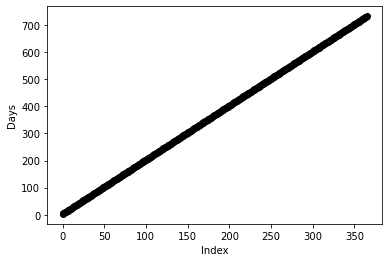

In [37]:
Rmax=[] ; Vmax=[] ; timeeddy=[] ; X1=[] ; Y1=[]
for h in MainEddy:  ## MainEddy should contain only the eddy to be tracked !!
    Rmax+=list(D[tracks['rmax1'][h,0]][0])
    Vmax+=list(D[tracks['velmax1'][h,0]][0])
    timeeddy+=list(D[tracks['step'][h,0]][0]*timestep+time[0])
    X1+=list(D[tracks['x1'][h,0]][0]) ; Y1+=list(D[tracks['y1'][h,0]][0])
plt.plot(timeeddy,'ok') ; timeeddy=np.array(timeeddy).astype(int)
plt.xlabel('Index') ; plt.ylabel('Days')

### Manual tracking (in case border crossing)

In [37]:
#### MANUAL SELECTION

#MainEddy=np.array([0,44]) ### QWA115
#DayEddy=np.array([[0,420],[422,720]])

MainEddy=np.array([0,158]) ### QWA204    <=== indicate the indivual tracks
DayEddy=np.array([[0,220],[221,360]])*timestep#  <== indicate the valid step range for each track   

In [ ]:
Rmax=[] ; Vmax=[] ; timeeddy=[] ; X1=[] ; Y1=[]
for ide,h in enumerate(MainEddy):
    steps=D[tracks['step'][h,0]][0]*timestep+time[0]  ## Adding time_h[0] in case of restart\
    ided=np.where((steps>=DayEddy[ide][0]) & (steps<=DayEddy[ide][1]))[0]

    Rmax+=list(D[tracks['rmax1'][h,0]][0][ided])
    Vmax+=list(D[tracks['velmax1'][h,0]][0][ided])
    timeeddy+=list(D[tracks['step'][h,0]][0][ided]*timestep+time[0])
    X1+=list(D[tracks['x1'][h,0]][0][ided]) ; Y1+=list(D[tracks['y1'][h,0]][0][ided])
plt.plot(timeeddy,'ok') ; timeeddy=np.array(timeeddy).astype(int)
plt.xlabel('Index') ; plt.ylabel('Days')

##  SST Scaling

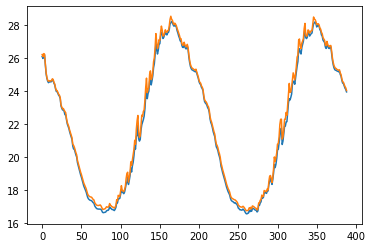

In [38]:
SSTmax_h=np.max(SST,axis=(1,2))   ### HIS version
SSTmin_h=np.min(SST,axis=(1,2))
SSTmean_h=np.mean(SST,axis=(1,2)) #nd.gaussian_filter1d(np.mean(temp_h[:,-1],axis=(1,2)),sigma=2)
plt.plot(SSTmin_h) ; plt.plot(SSTmean_h)

In [39]:
cust=cm.Spectral_r ; Ncycl=0
my_cmap = cust(np.arange(cust.N))
my_cmap[:,-1] = 1-0.9*(np.sin(np.linspace(0, Ncycl*np.pi, cust.N))**10) #np.linspace(0, 1, cust.N)
my_cmap = col.ListedColormap(my_cmap)

## SST & MLD maps with AMEDA

100%|██████████| 33/33 [00:00<00:00, 147.01it/s]
<ipython-input-46-ad94f66cb0a6>:49: UserWarning: FixedFormatter should only be used together with FixedLocator
  CB.ax.set_yticklabels(labels) ; CB.ax.tick_params(labelsize=25)


Text(0.5, 0.95, 'Run QWA116 - AE 1km ERA5 1-hour  - t= 185 days')

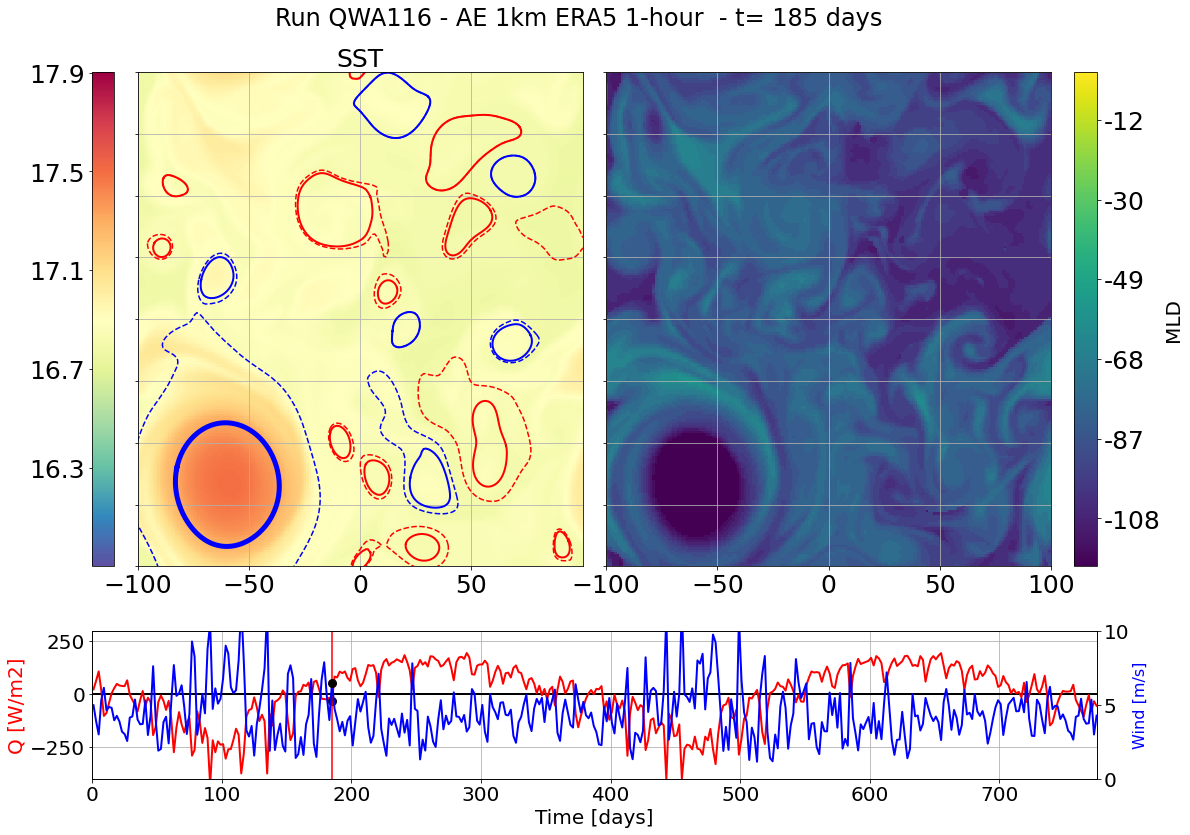

In [46]:
### Just 1 timstep
t=92  # chosen timestep
plot_number=False ;     ### To plot track number and be sure which one is plotted
dTmax=1                ### colorbar range
SSTticks=np.arange(SSTmean_h[t]-2.5-(SSTmean_h[t]-dTmax)%1, SSTmean_h[t]+2-(SSTmean_h[t]-dTmax)%1,0.4)

plt.figure(0, figsize=(18,13))
gs = GridSpec(2, 4, width_ratios=[1/20,1,1,1/20], height_ratios=[10,3], wspace=0.1, hspace=0.2)

### SST
plt.subplot(gs[0,1])
plt.pcolormesh(xi_rho,xi_rho,SST[t,:,:],vmin=SSTmean_h[t]-dTmax, vmax=SSTmean_h[t]+dTmax,cmap=cm.Spectral_r)

### Plotting AMEDA eddies
ListPs=np.where(StepEddy[:,t])[0]
for i in tqdm(range(len(ListPs))):
    if ListPs[i] in MainEddy:
        lw=5  ## THicker line for Main Eddy
    else:
        lw=2
    idt=np.where(D[tracks['step'][ListPs[i],0]][0]-1==t)[0]
    ### Plotting Rmax
    Contour=D[D[tracks['shapes1'][ListPs[i],0]][0][int(idt)]][:]
    plt.plot(Contour[:,0], Contour[:,1], '-', lw=lw, color=Color[ListPs[i]])
    if plot_number:
        plt.text(np.mean(Contour[:,0]), np.mean(Contour[:,1]), str(ListPs[i]))
    
    ### Plotting Rend
    Contour=D[D[tracks['shapes3'][ListPs[i],0]][0][int(idt)]][:]
    plt.plot(Contour[:,0], Contour[:,1], '--', color=Color[ListPs[i]])

plt.title('SST', size=25)  
plt.xlim([-Xmax,Xmax]) ; plt.ylim([-Xmax,Xmax]) ; plt.grid() #; plt.ylabel('Distance [km]', size=18)
plt.xticks(np.arange(-100,100,50))
plt.tick_params(labelleft=False, labelsize=25)
CB1=plt.colorbar(cax=plt.subplot(gs[0,0]))#, orientation='horizontal')
CB1.ax.set_xlim([SSTmean_h[t]-dTmax,SSTmean_h[t]+dTmax])
CB1.set_ticks(list(SSTticks),[ '%0.2f'%x for x in SSTticks ])
CB1.ax.tick_params(left=True, right=False, labelright=False, labelleft=True, labelsize=25)

plt.subplot(gs[0,2])  ### MLD
plt.pcolor(xi_rho, xi_rho,MLDind_h[t], vmin=np.argmin(np.abs(zvert+MLDmax)) , vmax=len(zvert)-1)
plt.xlim([-Xmax,Xmax]) ; plt.ylim([-Xmax,Xmax]) ; plt.grid()
plt.xticks(np.arange(-100,110,50))
plt.tick_params(labelleft=False, labelsize=25)
CB=plt.colorbar(cax=plt.subplot(gs[0,-1])) 
ticks=CB.get_ticks()
labels=['%3.0f'%(fmld(x)) for x in ticks]
CB.ax.set_yticklabels(labels) ; CB.ax.tick_params(labelsize=25)
CB.ax.set_ylabel('MLD', fontsize=20)

ax1=plt.subplot(gs[1,:])    ### Q 
plt.plot([0,time[-1]],[0,0],'-k',lw=2)
plt.plot(time, Qmean,'-r', lw=2) ; plt.grid()
plt.tick_params(labelsize=20)
tf=np.argmin(np.abs(time-time[t]))
plt.plot(time[tf], Qmean[tf],'ok', ms=8)
plt.plot([time[tf]]*2, [-500,400],'-r')
plt.ylabel('Q [W/m2]',size=20, color='r')
plt.ylim([-400,300])
plt.xlabel('Time [days]', size=20)

ax2=ax1.twinx()      ### Wind
ax2.plot(time, Wspeed,'-b',lw=2)
plt.plot(time[tf], Wspeed[tf],'ok', ms=8)
plt.tick_params(labelsize=20)
plt.ylabel('Wind [m/s]',size=16, color='b')
plt.xlim([0,time[-1]]) ; plt.ylim([0,10])

plt.suptitle(str_title+' - t= '+str(int(time[t]))+' days', size=24, y=0.95)


## Kappa & Epsilon sections

In [49]:
ided

124

Text(0.5, 0.9, 'Run QWA116 - AE 1km ERA5 1-hour  - t= 251 days')

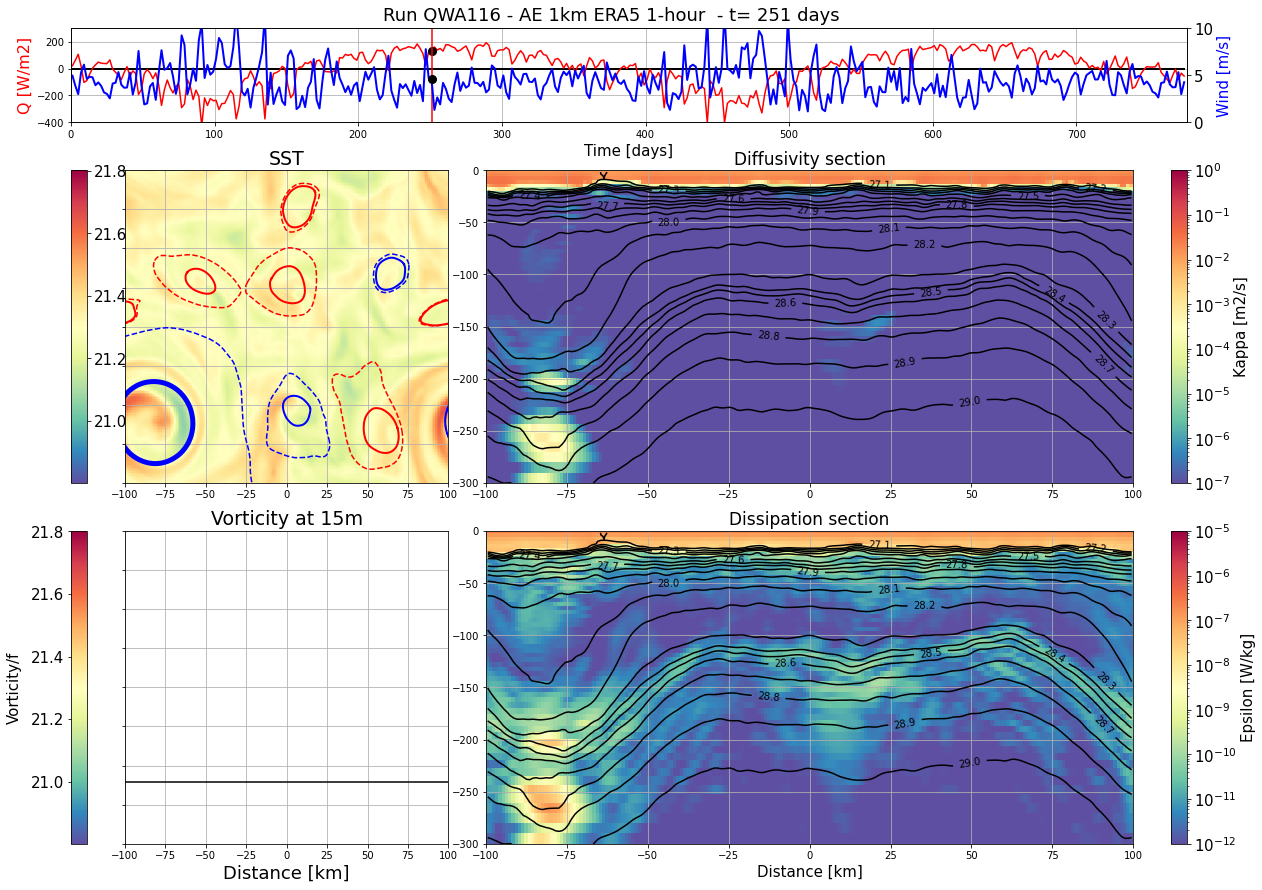

In [56]:
t=125  ### Just 1 timestep

T0=25 ; R0=26 ; Tcoef=0.28    
ided=np.argmin(np.abs(timeeddy-time_h[t])) ##np.where(timeeddy==t*timestep)[0]
idy=np.argmin(np.abs(xi_rho-Y1[ided]))   ## index of slice transect to cross eddy
Sigma=R0-Tcoef*(temp_h[t,:,idy]-T0)  ### Translating temperature to density

Levels=np.array(list(np.arange(25.5,27,0.3))+list(np.arange(27.1,29.2,0.1)))  ### Isopycnals shown
SSTticks=np.arange(SSTmean_h[t]-1.5-(SSTmean_h[t]-0.5)%1, SSTmean_h[t]+1.5-(SSTmean_h[t]-0.5)%1,0.2)

plt.figure(0, figsize=(20,15))
gs = GridSpec(3, 4, width_ratios=[0.5,10,20,0.5], height_ratios=[3,10,10], wspace=0.15, hspace=0.2)

plt.subplot(gs[1,1])           ### SST
plt.pcolormesh(xi_rho,xi_rho,temp_h[t,-1,:,:],vmin=SSTmean_h[t]-0.5, vmax=SSTmean_h[t]+0.5,cmap=my_cmap)#cm.RdYlBu_r)#Spectral_r)
ListPs=np.where(StepEddy[:,t])[0]
for i in range(len(ListPs)):
    if ListPs[i] in MainEddy:
        lw=5  ## THicker line for Main Eddy
    else:
        lw=2
    idt=np.where(D[tracks['step'][ListPs[i],0]][0]-1==t)[0]
    Contour=D[D[tracks['shapes1'][ListPs[i],0]][0][int(idt)]][:]         ### Plotting Rmax
    plt.plot(Contour[:,0], Contour[:,1], '-', lw=lw, color=Color[ListPs[i]])
    Contour=D[D[tracks['shapes3'][ListPs[i],0]][0][int(idt)]][:]         ### Plotting Rend
    plt.plot(Contour[:,0], Contour[:,1], '--', color=Color[ListPs[i]])

plt.title('SST', size=19)  
plt.plot([0,0],[0,0],'-r', label='Cyclone') ; plt.plot([0,0],[0,0],'-b', label='Anticyclone') #; plt.legend(loc=2, fontsize=13)
plt.xlim([-Xmax,Xmax]) ; plt.ylim([-Xmax,Xmax]) ; plt.grid()# ; plt.xlabel('Distance [km]', size=18)
plt.tick_params(labelleft=False)
CB1=plt.colorbar(cax=plt.subplot(gs[1,0]))
CB1.ax.tick_params(left=True, right=False, labelright=False, labelleft=True, labelsize=15)
CB1.ax.set_ylabel(u'Temperature [\N{DEGREE SIGN}C]', fontsize=15, labelpad=-80)
CB1.ax.set_ylim([SSTmean_h[t]-0.5,SSTmean_h[t]+0.5])
CB1.set_ticks(list(SSTticks),[ '%0.2f'%x for x in SSTticks ])

plt.subplot(gs[2,1])                      ### Vorticity
plt.pcolor(x_psi, y_psi, Vort[t,:], cmap=cm.seismic, vmin=-1, vmax=1)
idy=np.argmin(np.abs(xi_rho-Y1[t]))  ; plt.plot([-Xmax,Xmax],[xi_rho[idy]]*2,'-k')
plt.title('Vorticity at 15m', size=19) ; plt.xlabel('Distance [km]', size=18)
plt.xlim([-Xmax,Xmax]) ; plt.ylim([-Xmax,Xmax]) ; plt.grid() ; plt.tick_params(labelleft=False)
CB2=plt.colorbar(cax=plt.subplot(gs[2,0]))#, orientation='horizontal')
CB2.ax.set_ylabel('Vorticity/f', fontsize=15, labelpad=-80)
CB2.ax.tick_params(left=True, right=False, labelright=False, labelleft=True, labelsize=15)


ax1 = plt.subplot(gs[0,:])                 ### Q 
plt.plot([0,time[-1]],[0,0],'-k',lw=2) ;plt.plot(time, Qmean,'-r') ; plt.grid() ; plt.xlabel('Time [days]',size=15)
tf=np.argmin(np.abs(time-time_h[t]))
plt.plot(time[tf], Qmean[tf],'ok', ms=8) ; plt.plot([time[tf]]*2, [-400,300],'-r')
plt.ylabel('Q [W/m2]',color='r', size=16) ;plt.xlim([0,time_h[-1]]) ; plt.ylim([-400,300])

ax2=ax1.twinx()                      ### Wind
ax2.plot(time, Wspeed,'-b',lw=2) ; plt.plot(time[tf], Wspeed[tf],'ok', ms=8)
plt.ylabel('Wind [m/s]',size=15, color='b')
plt.xlim([0,time_h[-1]]) ; plt.ylim([0,10]) ; plt.tick_params(labelsize=15)

plt.subplot(gs[1,2])                ### AKv
CP0=plt.pcolor(xi_rho, z_dzt, AKv[t,:,idy], cmap=cm.Spectral_r, norm=col.LogNorm(vmin=1e-7, vmax=1e-0))# vmin=1e-4, vmax=0.1)
CP2=plt.contour(xi_rho, zvert, Sigma, colors=['k'],levels=Levels)
plt.clabel(CP2, Levels, fmt='%3.1f')
plt.xlim([-Xmax,Xmax]) ; plt.ylim([-300,0]) ; plt.grid()
plt.title('Diffusivity section',size=17) #; plt.xlabel('Distance [km]',size=15)
CB2=plt.colorbar(CP0,cax=plt.subplot(gs[1,3]), orientation='vertical')
CB2.ax.set_ylabel('Kappa [m2/s]', fontsize=15)
CB2.ax.tick_params(labelsize=15)

plt.subplot(gs[2,2])                  ### Epsilon
CP1=plt.pcolor(xi_rho, z_dzt, Eps[t,:,idy], cmap=cm.Spectral_r, norm=col.LogNorm(vmin=1e-12, vmax=1e-5))# vmin=1e-4, vmax=0.1)
CP2=plt.contour(xi_rho, zvert, Sigma, colors=['k'],levels=Levels)
plt.clabel(CP2, Levels, fmt='%3.1f')
plt.xlim([-Xmax,Xmax]) ; plt.ylim([-300,0]) ; plt.grid()
plt.title('Dissipation section',size=17) ; 
plt.xlabel('Distance [km]',size=15)
CB2=plt.colorbar(CP1, cax=plt.subplot(gs[2,3]), orientation='vertical')
CB2.ax.set_ylabel('Epsilon [W/kg]', fontsize=15)
CB2.ax.tick_params(labelsize=15)

plt.suptitle(str_title+' - t= '+str(int(time[t]))+' days', size=18, y=0.90)

## Movie  (SST & MLD)

In [57]:
path_save='../../Analysis/QWA_test/'   ### path to save .png to be compiled in .mp4
moviename='test'
path_save, moviename

('../../Analysis/QWA_test/', 'test')

In [55]:
dTmax=0.5

for t in tqdm(range(0,20,2)):
    
    SSTticks=np.arange(SSTmean_h[t]-2.5-(SSTmean_h[t]-dTmax)%1, SSTmean_h[t]+2-(SSTmean_h[t]-dTmax)%1,0.4)

    plt.figure(0, figsize=(18,13))
    gs = GridSpec(2, 4, width_ratios=[1/20,1,1,1/20], height_ratios=[10,3], wspace=0.1, hspace=0.2)

    ### SST
    plt.subplot(gs[0,1])
    plt.pcolormesh(xi_rho,xi_rho,SST[t,:,:],vmin=SSTmean_h[t]-dTmax, vmax=SSTmean_h[t]+dTmax,cmap=cm.Spectral_r)

    ### Plotting AMEDA eddies
    ListPs=np.where(StepEddy[:,t])[0]
    for i in tqdm(range(len(ListPs))):
        if ListPs[i] in MainEddy:
            lw=5  ## THicker line for Main Eddy
        else:
            lw=2
        idt=np.where(D[tracks['step'][ListPs[i],0]][0]-1==t)[0]
        ### Plotting Rmax
        Contour=D[D[tracks['shapes1'][ListPs[i],0]][0][int(idt)]][:]
        plt.plot(Contour[:,0], Contour[:,1], '-', lw=lw, color=Color[ListPs[i]])
        if plot_number:
            plt.text(np.mean(Contour[:,0]), np.mean(Contour[:,1]), str(ListPs[i]))

        ### Plotting Rend
        Contour=D[D[tracks['shapes3'][ListPs[i],0]][0][int(idt)]][:]
        plt.plot(Contour[:,0], Contour[:,1], '--', color=Color[ListPs[i]])

    plt.title('SST', size=25)  
    plt.xlim([-Xmax,Xmax]) ; plt.ylim([-Xmax,Xmax]) ; plt.grid() #; plt.ylabel('Distance [km]', size=18)
    plt.xticks(np.arange(-100,100,50))
    plt.tick_params(labelleft=False, labelsize=25)
    CB1=plt.colorbar(cax=plt.subplot(gs[0,0]))#, orientation='horizontal')
    CB1.ax.set_xlim([SSTmean_h[t]-dTmax,SSTmean_h[t]+dTmax])
    CB1.set_ticks(list(SSTticks),[ '%0.2f'%x for x in SSTticks ])
    CB1.ax.tick_params(left=True, right=False, labelright=False, labelleft=True, labelsize=25)

    plt.subplot(gs[0,2])  ### MLD
    plt.pcolor(xi_rho, xi_rho,MLDind_h[t], vmin=np.argmin(np.abs(zvert+MLDmax)) , vmax=len(zvert)-1)
    plt.xlim([-Xmax,Xmax]) ; plt.ylim([-Xmax,Xmax]) ; plt.grid()
    plt.xticks(np.arange(-100,110,50))
    plt.tick_params(labelleft=False, labelsize=25)
    CB=plt.colorbar(cax=plt.subplot(gs[0,-1])) 
    ticks=CB.get_ticks()
    labels=['%3.0f'%(f(x)) for x in ticks]
    CB.ax.set_yticklabels(labels) ; CB.ax.tick_params(labelsize=25)
    CB.ax.set_ylabel('MLD', fontsize=20)

    ax1=plt.subplot(gs[1,:])    ### Q 
    plt.plot([0,time[-1]],[0,0],'-k',lw=2)
    plt.plot(time, Qmean,'-r', lw=2) ; plt.grid()
    plt.tick_params(labelsize=20)
    tf=np.argmin(np.abs(time-time[t]))
    plt.plot(time[tf], Qmean[tf],'ok', ms=8)
    plt.plot([time[tf]]*2, [-500,400],'-r')
    plt.ylabel('Q [W/m2]',size=20, color='r')
    plt.ylim([-400,300])
    plt.xlabel('Time [days]', size=20)

    ax2=ax1.twinx()      ### Wind
    ax2.plot(time, Wspeed,'-b',lw=2)
    plt.plot(time[tf], Wspeed[tf],'ok', ms=8)
    plt.tick_params(labelsize=20)
    plt.ylabel('Wind [m/s]',size=16, color='b')
    plt.xlim([0,time[-1]]) ; plt.ylim([0,10])

    plt.suptitle(str_title+' - t= '+str(int(time[t]))+' days', size=24, y=0.95)
############
    plt.tight_layout()
    plt.savefig(path_save+'SST_Vort_t='+'%4.0f'%(time[t]*10)+'.png')
    plt.close()

100%|██████████| 1/1 [00:00<00:00, 139.83it/s]
<ipython-input-55-4e556e569d49>:84: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
100%|██████████| 1/1 [00:00<00:00, 133.60it/s]
<ipython-input-55-4e556e569d49>:84: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
100%|██████████| 1/1 [00:00<00:00, 134.07it/s]
<ipython-input-55-4e556e569d49>:84: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
100%|██████████| 1/1 [00:00<00:00, 110.46it/s]
<ipython-input-55-4e556e569d49>:84: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
100%|██████████| 1/1 [00:00<00:00, 89.77it/s]
<ipython-input-55-4e556e569d49>:84: UserWarning: This figure includes Axes that are no

In [58]:
"""
Quick and dirty script for .mp4 using imageio
"""
import imageio
import os

"""
Create .mp4 from series of pictures stored at path dir_fig,
Change filename loop for picture selection, picture name or extension (.png /.jpg /.tif)

Default fps should be 12, make additional operations using FFMPEG in the terminal
Command line to slow down by a factor of 8:
$ ffmpeg  -i input.mp4 -vf  "setpts=8*PTS" output_slow.mp4

Code can be reused to produce .gif
"""
kargs = { 'macro_block_size': None }#, 'ffmpeg_params': [ '-r', '12']}

filelist=os.listdir(path_save)
filelist=np.sort(filelist)
if filelist[0]=='.ipynb_checkpoints':
    filelist=filelist[1:] #to remove '.ipynb_checkpoints'
images = []

for k in tqdm(range(len(filelist))):
    filename=path_save+filelist[k]  ###   <========== CHANGE FILENAME HERE #######
    images.append(imageio.imread(filename))
   
imageio.mimwrite(path_save+'../../'+moviename+'.mp4', images, 'MP4', fps=2)#**kargs)   ####  <===== Change movie.mp4 name here
#imageio.mimsave(dir_fig+'Tmax-Temp-SLA_scatter+Bin_'+str(YEAR[0])+'-'+str(YEAR[-1])+'.gif', images, fps=1)

100%|██████████| 10/10 [00:00<00:00, 22.06it/s]
IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (1296, 936) to (1296, 944) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).
